## 1. Air quality data preparation

In [1]:
import sys, os
import pandas as pd
sys.path.append("../")
import matplotlib.pyplot as plt 
from Clust.clust.preprocessing import processing_interface

In [2]:
data_name = 'air2'
if data_name =='air1': # ['in_co2', 'in_humi', 'in_noise', 'in_pm01', 'in_pm10', 'in_pm25','in_temp', 'in_voc']
    data = pd.read_csv("./data/outlier_test.csv", parse_dates=True, index_col='time' )
if data_name =='air2': # ['in_co2', 'in_humi', 'in_noise', 'in_pm01', 'in_pm10', 'in_pm25','in_temp', 'in_voc']
    data = pd.read_csv("./data/test_file.csv", parse_dates=True, index_col='time' )
"""
# 활용 안함

elif data_name =='uci_har':
    # File
    data_dir = './data/uci_har_outlier_data.csv'
    data = pd.read_csv(data_dir) # shape: [10299, 40]
    data.index = pd.date_range(start='1/1/2018', end='1/08/2018', periods = len(data))
    period = 24


elif data_name =='random':
    # Generate test data
    import numpy as np
    period = 24
    test_signal = np.concatenate(
        [np.random.normal(0.7, 0.05, 300), 
         np.random.normal(1.5, 0.05, 300),
         np.random.normal(0.6, 0.05, 300),
         np.random.normal(1.3, 0.05, 300)])
    data = pd.DataFrame(test_signal, columns=['test'], index = pd.date_range(start='1/1/2018', end='1/08/2018', periods = len(test_signal)))
"""
print(data.isna().sum())

in_co2      0
in_humi     0
in_noise    0
in_pm01     0
in_pm10     0
in_pm25     0
in_temp     0
in_voc      0
dtype: int64


In [3]:
refine_param = {'remove_duplication': {'flag': True}, 'static_frequency': {'flag': True, 'frequency': None}}

refine_data = processing_interface.get_data_result('refinement', data , refine_param)
print(refine_data.isna().sum())

in_co2      6124
in_humi     6124
in_noise    6124
in_pm01     6124
in_pm10     6124
in_pm25     6124
in_temp     6124
in_voc      6124
dtype: int64


In [4]:
certain_param = {'flag': True,
'abnormal_value_list': [99.9, 199.9, 299.9, 9999, -99.9, -199.9, -299.9, -9999, -9999.0] ,
 'data_min_max_limit': {'max_num': {'in_temp': 80,
   'in_humi': 100,
   'in_co2': 10000,
   'in_voc': 60000,
   'in_noise': 90,
   'in_pm10': 1000,
   'in_pm25': 1000,
   'in_pm01': 1000},
  'min_num': {'in_temp': -40,
   'in_humi': 0,
   'in_co2': 0,
   'in_voc': 0,
   'in_noise': 35,
   'in_pm10': 0,
   'in_pm25': 0,
   'in_pm01': 0}}}
# 4) 명확하게 이상 데이터에 대해서 NaN으로 처리함
more_certain_NaN = processing_interface.get_data_result('certain_error_to_NaN', refine_data, certain_param)
print(more_certain_NaN.isna().sum())

in_co2      6124
in_humi     6124
in_noise    6146
in_pm01     6124
in_pm10     6124
in_pm25     6124
in_temp     6124
in_voc      6125
dtype: int64


## 2. Data EDA

<Axes: xlabel='time'>

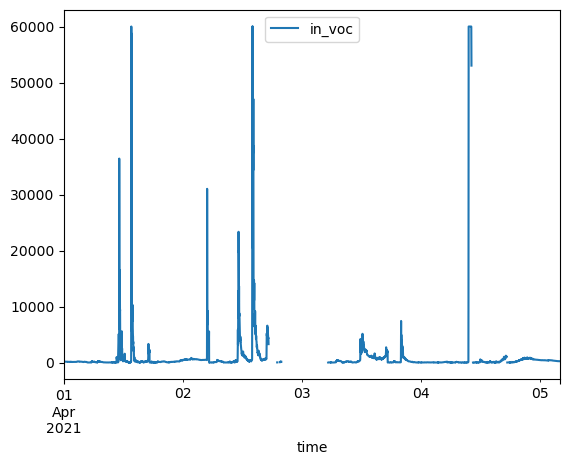

In [5]:
data = more_certain_NaN[['in_voc']][:6000]
data.plot()

## 3. Uncertain data preprocessing

In [6]:
period = 60 * 24  # 1분단위 * 60 * 24
percentile1 = 95

parameter = {
    "SR":{ 
        # Multivariable 불가능
        # percentile만 조절
        'SR_series_window_size': int(period/2), # less than period, int, 데이터 크기에 적합하게 설정
        'SR_spectral_window_size': period, # as same as period, int, 데이터 크기에 적합하게 설정
        'SR_score_window_size': period *  2 }, # a number enough larger than period, int, period보다 충분히 큰 size로 설정
  
    "IF":{ # Estimators (1~100)
        # percentile만 조절
        'IF_estimators': 100, # ensemble에 활용하는 모델 개수, i(default: 100, 데이터 크기에 적합하게 설정) 
        'IF_max_samples': 'auto', # 각 모델에 사용하는 샘플 개수(샘플링 적용), int or float(default: 'auto') 
        'IF_contamination': (100-percentile1)/100, #'auto', # 모델 학습시 활용되는 데이터의 outlier 비율, ‘auto’ or float(default: ’auto’, float인 경우 0 초과, 0.5 이하로 설정)
        'IF_max_features': 1.0, # 각 모델에 사용하는 변수 개수(샘플링 적용), int or float(default: 1.0)
        'IF_bootstrap': True}, # bootstrap적용 여부, bool(default: False)
    
    "KDE":{ #leafSize (1~100)
        # Multivariable 가능
        'KDE_bandwidth': 1.0, # kernel의 대역폭, float(default: 1.0)
        'KDE_algorithm': 'auto', # 사용할 tree 알고리즘, {‘kd_tree’,‘ball_tree’,‘auto’}(default: ’auto’) 중 택 1
        'KDE_kernel': 'gaussian', # kernel 종류, {'gaussian’, ‘tophat’, ‘epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’}(default: ’gaussian’) 중 택 1
        'KDE_metric': 'euclidean', # 사용할 거리 척도, str(default: ’euclidean’)
        'KDE_breadth_first': True, # breadth(너비) / depth(깊이) 중 우선순위 방식 정의, bool, True: breadth or False: depth
        'KDE_leaf_size': 40}, # tree 알고리즘에서의 leaf node 개수, int(default: 40)}
    
    "LOF":{ # Neighbors (1~100) , leafSize (1~100, Integer)
        # percentile만 조절
        'LOF_neighbors': 20, # 가까운 이웃 개수, int(default: 20)
        'LOF_algorithm': 'auto', # 가까운 이웃을 정의하기 위한 알고리즘, {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}(default: ’auto’) 중 택 1
        'LOF_leaf_size': 30, # tree 알고리즘에서의 leaf node 개수, int(default: 30)
        'LOF_metric': 'minkowski', # 이웃을 정의하기 위한 거리 척도, str or callable(default: ’minkowski’)
        'LOF_contamination': (100-percentile1)/100 # 오염 정도 (default: 0.2) (0~0.2]
    },
    "MoG": { #Components(1~100)
        'MoG_components': 1, # mixture에 활용하는 component의 개수, int(default: 1)
        'MoG_covariance': 'full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}(default: ’full’) 중 택 1
        'MoG_max_iter': 100 # EM 방법론 반복 횟수, int(default: 100)
    },
    "IQR":{ # weight (1~100)
        'weight':100},
    
    "SD":{# limit (1~100)
        "period":period, "limit":15} 
}

from Clust.clust.preprocessing.errorDetection.unCertainError import unCertainErrorRemove
from Clust.clust.preprocessing.errorDetection import dataOutlier

## Outlier Detector
AlgorithmList =[ 'IF', 'KDE', 'LOF', 'MoG', 'SR', 'IQR', 'SD']

## 2. Parameter test

In [7]:
algorithm1 = AlgorithmList[1]
"""
# 아래와 같이 여러개의 알고리즘을 병렬로 활용도 가능
un_certain= {"outlierDetectorConfig":[
    {'algorithm': AlgorithmList[0], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[0]]},
    {'algorithm': AlgorithmList[1], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[1]]}
]}
"""
un_certain= {"outlierDetectorConfig":[
    {'algorithm': algorithm1, 'percentile':percentile1 ,'alg_parameter': parameter[algorithm1]}
]}
uncertain_param={"flag":True, "param": un_certain}

uncertain_param

{'flag': True,
 'param': {'outlierDetectorConfig': [{'algorithm': 'KDE',
    'percentile': 95,
    'alg_parameter': {'KDE_bandwidth': 1.0,
     'KDE_algorithm': 'auto',
     'KDE_kernel': 'gaussian',
     'KDE_metric': 'euclidean',
     'KDE_breadth_first': True,
     'KDE_leaf_size': 40}}]}}

In [8]:
from Clust.clust.preprocessing import processing_interface
more_uncertain_nan = processing_interface.get_data_result('uncertain_error_to_NaN', data, uncertain_param)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


<Axes: xlabel='time'>

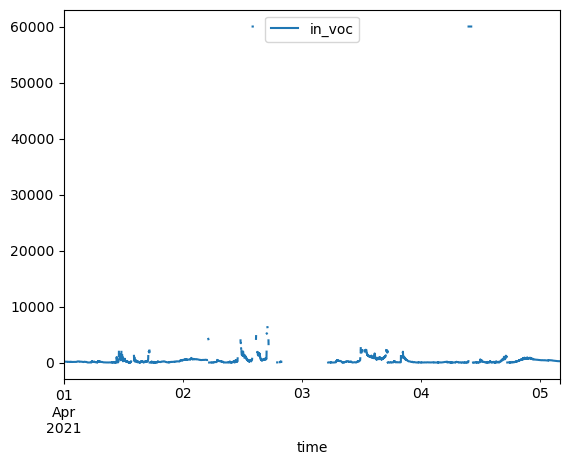

In [9]:
more_uncertain_nan.plot()

## 3. Deep test
#### 아래 코드는 위를 심도있게 테스트 해보는 코드로 이해 어려울 경우 생략, 어떤 데이터들이 삭제되었는지 알 수 있음

In [10]:
from Clust.clust.preprocessing.errorDetection.unCertainError import unCertainErrorRemove
from Clust.clust.preprocessing.errorDetection import dataOutlier

data_outlier = unCertainErrorRemove(data, un_certain)
outlierIndex = data_outlier.getNoiseIndex()
result = data_outlier.getDataWithoutUncertainError(outlierIndex)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


In [11]:
data_outlier.outlierIndex

{'KDE': {'in_voc': DatetimeIndex(['2021-04-01 10:59:00+00:00', '2021-04-01 11:00:00+00:00',
                 '2021-04-01 11:01:00+00:00', '2021-04-01 11:04:00+00:00',
                 '2021-04-01 11:05:00+00:00', '2021-04-01 11:06:00+00:00',
                 '2021-04-01 11:07:00+00:00', '2021-04-01 11:08:00+00:00',
                 '2021-04-01 11:09:00+00:00', '2021-04-01 11:10:00+00:00',
                 ...
                 '2021-04-03 20:11:00+00:00', '2021-04-03 20:12:00+00:00',
                 '2021-04-03 20:13:00+00:00', '2021-04-03 20:14:00+00:00',
                 '2021-04-03 20:16:00+00:00', '2021-04-03 20:24:00+00:00',
                 '2021-04-03 20:36:00+00:00', '2021-04-04 09:31:00+00:00',
                 '2021-04-04 10:05:00+00:00', '2021-04-04 10:06:00+00:00'],
                dtype='datetime64[ns, UTC]', name='time', length=300, freq=None)}}

In [12]:
intersectionIndex = data_outlier.getIntersectionIndex(outlierIndex)

in_voc


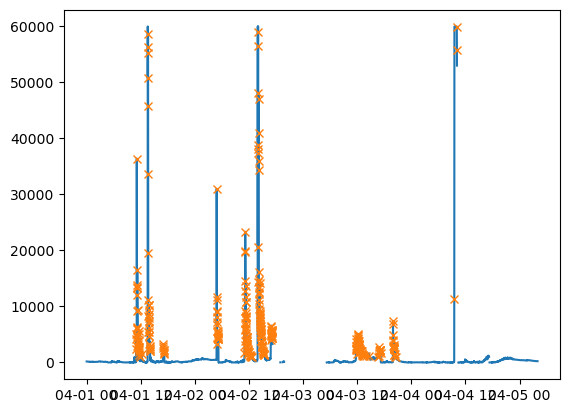

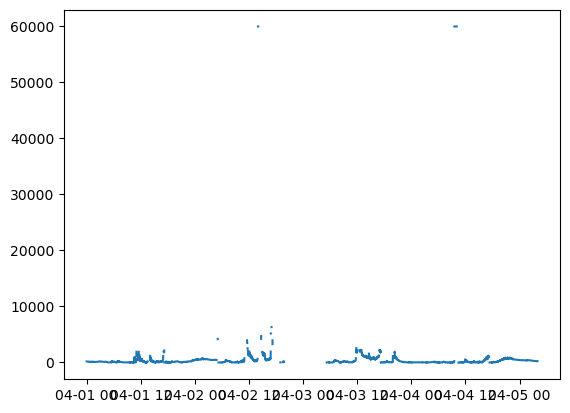

In [13]:
dataOutlier.showResult(data_outlier.data, result, outlierIndex)